In [3]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw
)
from plotnine.scales import scale_y_log10, scale_x_log10
import os

In [13]:
import torch
import numpy as np
from tqdm import tqdm
import math

DEVICE = "cpu"

In [84]:
data = pd.read_csv(f"logs/4-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
print(data["sft"].unique())
print(data["sft_amount"].unique())
data

[   0    1   10   20   30   40   50   60  100  150  200  250  300  400
  500  600  800 1000 1200 1500 2000 2500 3000 4000 5000 6000]
[   0   50  250  500 1000 2500 5000]


,Unnamed: 0,shots,k,hmm,sft,sft_amount,prob,acc,nll
0,0,0,3,0,0,0,0.226609,0.370370,1.772636
1,1,0,3,0,1,50,0.391075,0.680556,1.083433
2,2,0,3,0,1,250,0.434198,0.736111,0.949646
3,3,0,3,0,1,500,0.453500,0.819444,0.892285
4,4,0,3,0,1,1000,0.456069,0.865741,0.871469
...,...,...,...,...,...,...,...,...,...
135875,135875,255,3,4,3000,2500,0.083008,0.110465,5.508345
135876,135876,255,3,4,3000,5000,0.079005,0.093023,5.541188
135877,135877,255,3,4,4000,5000,0.077644,0.093023,5.652903
135878,135878,255,3,4,5000,5000,0.076812,0.087209,5.676421


In [85]:
filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

In [86]:
data

,Unnamed: 0,shots,k,hmm,sft,sft_amount,prob,acc,nll
0,0,0,3,0,0,0,0.226609,0.370370,1.772636
13,13,0,3,0,60,50,0.391857,0.675926,1.081651
21,21,0,3,0,300,250,0.433783,0.726852,0.952783
27,27,0,3,0,600,500,0.453057,0.814815,0.894260
33,33,0,3,0,1200,1000,0.452990,0.861111,0.879554
...,...,...,...,...,...,...,...,...,...
135858,135858,255,3,4,300,250,0.153366,0.215116,3.358529
135864,135864,255,3,4,600,500,0.115279,0.174419,4.186858
135870,135870,255,3,4,1200,1000,0.087596,0.110465,4.986712
135875,135875,255,3,4,3000,2500,0.083008,0.110465,5.508345


In [159]:
class BayesianLawFit(torch.nn.Module):
    def __init__(self, num_hmms, sft_amounts=None):
        super(BayesianLawFit, self).__init__()
        self.num_hmms = num_hmms
        self.masks = torch.eye(num_hmms, dtype=torch.bool).to(DEVICE)
        self.sft_amount_d = {sft: i for i, sft in enumerate(sft_amounts)}
        self.sft_amounts = np.vectorize(self.sft_amount_d.get)
        self.priors = torch.nn.Parameter(torch.zeros(len(sft_amounts), num_hmms))
        self.gammas = torch.nn.Parameter(torch.zeros(num_hmms) + 1)
        self.betas = torch.nn.Parameter(torch.zeros(num_hmms) - 1)
        self.K = torch.nn.Parameter(torch.zeros(len(sft_amounts)))
    
    def get_prior(self, sft_amount=None):
        return torch.nn.functional.softmax(self.priors[sft_amount], dim=-1)

    def get_gammas(self):
        return torch.sigmoid(self.gammas)

    def get_betas(self):
        return torch.sigmoid(self.betas)
    
    def get_K(self, sft_amount=None):
        return torch.exp(self.K[sft_amount])

    def get_params(self):
        return {
            "priors": self.get_prior().tolist(),
            "gammas": self.get_gammas().tolist(),
            "betas": self.get_betas().tolist(),
            "K": self.get_K().tolist(),
        }

    def forward(self, shots, hmm, sft_amount):
        sft_amount = torch.tensor(self.sft_amounts(sft_amount.numpy())).to(DEVICE)
        priors = self.get_prior(sft_amount).log()
        gammas = self.get_gammas().log()
        betas = self.get_betas().log()
        K = self.get_K(sft_amount)
        shots = shots * K
        if isinstance(shots, torch.Tensor):
            shots = shots.unsqueeze(-1)
        # print("hmm:", hmm)
        # print("K:", self.K.item())
        # print("p(hmm):", priors.exp().tolist())
        p_under_dist = torch.where(self.masks[hmm], gammas, betas)
        # print("p(d | hmm):", p_under_dist.exp().tolist())
        p_seq_under_dist = p_under_dist * shots
        # print("p(D | hmm):", p_seq_under_dist.exp().tolist())
        posteriors = torch.nn.functional.softmax(priors + p_seq_under_dist, dim=-1) # already in log space
        # print("p(hmm | D):", posteriors.tolist())
        p_data = (posteriors * p_under_dist.exp()).sum(dim=-1)
        # print("p(d | D, hmm):", (posteriors * p_under_dist.exp()).tolist())
        # print("p(d | D):", p_data.item())
        est_nll = -torch.log(p_data)
        # print("NLL:", nll, est_nll.item())
        # input()
        return est_nll


def fit_bayesian_law(subset: pd.DataFrame, sft_amount=False):
    # fit power law
    sft_amounts = None if not sft_amount else list(subset['sft_amount'].unique())
    model = BayesianLawFit(len(subset['hmm'].unique()), sft_amounts)
    model.to(DEVICE)
    iterator = tqdm(range(100))
    patience = 5
    batch_size = 20
    history = []
    subset = subset.sample(frac=1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

    for _ in iterator:
        avg_loss = 0.0
        loss = 0.0
        for i in range(0, len(subset), batch_size):
            optimizer.zero_grad()
            batch = subset.iloc[i:i+batch_size]
            shots = torch.tensor(batch['shots'].values, dtype=torch.float32).to(DEVICE)
            hmm = torch.tensor(list(map(int, batch['hmm'].values)), dtype=torch.int32).to(DEVICE)
            true_nll = torch.tensor(batch['nll'].values, dtype=torch.float32).to(DEVICE)
            if sft_amount:
                sft_amounts = torch.tensor(batch['sft_amount'].values, dtype=torch.float32).to(DEVICE)
                est_nll = model(shots, hmm, sft_amounts)
            else:
                est_nll = model(shots, hmm)
            loss = ((true_nll - est_nll)**2).sum()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        # print
        avg_loss /= len(subset)
        history.append(avg_loss)
        result = {
            "loss": avg_loss,
            "gamma_0": model.get_gammas()[0].item(),
            "beta_0": model.get_betas()[0].item(),
            "K": model.get_K().tolist(),
        }
        # result.update({f"p_{i}": p.item() for i, p in enumerate(model.get_prior())})
        iterator.set_postfix(result)

        # early stopping
        if len(history) > patience and all([math.isclose(history[-1], x, rel_tol=5e-3) for x in history[-patience:]]):
            break
    
    return model

In [160]:
laws = {}
for k in data["k"].unique():
    laws[k] = fit_bayesian_law(data[data["k"] == k], True)

 11%| | 11/100 [00:05<00:48,  1.85it/s, loss=0.0358, gamma_0=0.311, beta_0=0.000632, K=[[0.07112370431423187, 0.0009886700427159667, 0.0005909169558435678, 0.00038286272319965065, 2.
 12%| | 12/100 [00:04<00:31,  2.79it/s, loss=0.0249, gamma_0=0.462, beta_0=0.000637, K=[[0.1254860907793045, 0.005258552264422178, 0.0009828738402575254, 0.0006298664375208318, 0.000
 13%|▏| 13/100 [00:03<00:20,  4.25it/s, loss=0.0241, gamma_0=0.494, beta_0=0.00119, K=[[0.17329220473766327, 0.022147927433252335, 0.0019079154590144753, 0.0012471760855987668, 0.000
 14%|▏| 14/100 [00:02<00:16,  5.18it/s, loss=0.022, gamma_0=0.473, beta_0=0.00121, K=[[2.7881813049316406, 0.037262726575136185, 0.0023702739272266626, 0.0013983349781483412, 0.00043


In [139]:
laws2 = {}
for k in data["k"].unique():
    laws2[k] = fit_bayesian_law(data[(data["k"] == k)], True)

 13%|▏| 13/100 [00:07<00:48,  1.80it/s, loss=0.0346, gamma_0=0.289, beta_0=0.000897, K=[[0.00030545529443770647, 0.0005827879649586976, 0.0003579394251573831, 0.0003132403944619, 1.8
 10%| | 10/100 [00:03<00:32,  2.76it/s, loss=0.0247, gamma_0=0.458, beta_0=0.000802, K=[[0.09435175359249115, 0.003935779444873333, 0.0010516822803765535, 0.0006768961320631206, 0.00
 14%|▏| 14/100 [00:03<00:20,  4.27it/s, loss=0.0246, gamma_0=0.492, beta_0=0.000976, K=[[0.205801323056221, 0.020249564200639725, 0.0018574621062725782, 0.00131703051738441, 0.000337
 14%|▏| 14/100 [00:02<00:16,  5.19it/s, loss=0.0214, gamma_0=0.488, beta_0=0.00125, K=[[1.6464567184448242, 0.05028180032968521, 0.002463787794113159, 0.0012272702297195792, 0.000407


In [162]:
laws3 = {}
for k in data["k"].unique():
    for sft_amount in data["sft_amount"].unique():
        print(k, sft_amount)
        laws3[(k, sft_amount)] = fit_bayesian_law(data[(data["k"] == k) & (data["sft_amount"] == sft_amount)], True)

3 0


 14%|██████████▊                                                                  | 14/100 [00:01<00:06, 12.83it/s, loss=0.0198, gamma_0=0.0971, beta_0=0.1, K=[[0.3156296908855438]]]


3 50


 11%|████████▏                                                                 | 11/100 [00:00<00:06, 12.78it/s, loss=0.0231, gamma_0=0.216, beta_0=0.0339, K=[[0.11742722243070602]]]


3 250


 27%|███████████████████▋                                                     | 27/100 [00:02<00:05, 13.48it/s, loss=0.0273, gamma_0=0.295, beta_0=0.007, K=[[0.0013071184512227774]]]


3 500


 19%|█████████████▍                                                         | 19/100 [00:01<00:06, 13.28it/s, loss=0.0295, gamma_0=0.285, beta_0=0.00381, K=[[0.0006768625462427735]]]


3 1000


 28%|███████████████████▉                                                   | 28/100 [00:02<00:05, 13.50it/s, loss=0.0292, gamma_0=0.321, beta_0=0.00249, K=[[0.0001659908302826807]]]


3 2500


 33%|███████████████████████▍                                               | 33/100 [00:02<00:04, 13.57it/s, loss=0.0323, gamma_0=0.296, beta_0=0.00138, K=[[9.889642387861386e-05]]]


3 5000


 29%|████████████████████▎                                                 | 29/100 [00:02<00:05, 13.43it/s, loss=0.0346, gamma_0=0.297, beta_0=0.00093, K=[[0.00010132098395843059]]]


5 0


 77%|█████████████████████████████████████████████████████████▊                 | 77/100 [00:03<00:01, 20.39it/s, loss=0.00272, gamma_0=0.316, beta_0=0.173, K=[[0.3348957598209381]]]


5 50


  9%|██████▋                                                                   | 9/100 [00:00<00:05, 17.99it/s, loss=0.00563, gamma_0=0.394, beta_0=0.0562, K=[[0.13388900458812714]]]


5 250


 17%|████████████▌                                                             | 17/100 [00:00<00:04, 19.06it/s, loss=0.0153, gamma_0=0.408, beta_0=0.0188, K=[[0.05178307369351387]]]


5 500


 57%|█████████████████████████████████████████▌                               | 57/100 [00:02<00:02, 20.25it/s, loss=0.0208, gamma_0=0.495, beta_0=0.0071, K=[[0.001323391799814999]]]


5 1000


 28%|████████████████████▏                                                   | 28/100 [00:01<00:03, 19.76it/s, loss=0.0224, gamma_0=0.558, beta_0=0.00422, K=[[0.000476528744911775]]]


5 2500


 37%|█████████████████████████▉                                            | 37/100 [00:01<00:03, 20.17it/s, loss=0.0289, gamma_0=0.466, beta_0=0.00187, K=[[0.00016478219185955822]]]


5 5000


 36%|█████████████████████████▌                                             | 36/100 [00:01<00:03, 20.06it/s, loss=0.0322, gamma_0=0.466, beta_0=0.00105, K=[[0.0001428651885362342]]]


8 0


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [00:02<00:00, 29.79it/s, loss=0.00154, gamma_0=0.413, beta_0=0.219, K=[[1.288203239440918]]]


8 50


 24%|█████████████████▊                                                        | 24/100 [00:00<00:02, 29.18it/s, loss=0.00285, gamma_0=0.435, beta_0=0.103, K=[[0.29537564516067505]]]


8 250


 19%|██████████████                                                            | 19/100 [00:00<00:02, 28.93it/s, loss=0.0114, gamma_0=0.454, beta_0=0.0273, K=[[0.10307203233242035]]]


8 500


 71%|███████████████████████████████████████████████████                     | 71/100 [00:02<00:00, 29.77it/s, loss=0.0189, gamma_0=0.56, beta_0=0.00374, K=[[0.0021470938809216022]]]


8 1000


 38%|███████████████████████████▎                                            | 38/100 [00:01<00:02, 29.61it/s, loss=0.0231, gamma_0=0.601, beta_0=0.0066, K=[[0.0011758238542824984]]]


8 2500


 41%|█████████████████████████████                                          | 41/100 [00:01<00:01, 29.55it/s, loss=0.0333, gamma_0=0.507, beta_0=0.00223, K=[[0.0004206825396977365]]]


8 5000


 42%|█████████████████████████████▊                                         | 42/100 [00:01<00:01, 29.59it/s, loss=0.0397, gamma_0=0.482, beta_0=0.00127, K=[[0.0002859374217223376]]]


10 0


 16%|████████████▏                                                               | 16/100 [00:00<00:02, 34.30it/s, loss=0.00131, gamma_0=0.43, beta_0=0.285, K=[[2.3821067810058594]]]


10 50


  8%|██████                                                                     | 8/100 [00:00<00:02, 32.38it/s, loss=0.00214, gamma_0=0.444, beta_0=0.0984, K=[[0.3537633717060089]]]


10 250


 16%|███████████▋                                                             | 16/100 [00:00<00:02, 34.23it/s, loss=0.00925, gamma_0=0.444, beta_0=0.0337, K=[[0.12948305904865265]]]


10 500


 91%|████████████████████████████████████████████████████████████████▌      | 91/100 [00:02<00:00, 36.09it/s, loss=0.0179, gamma_0=0.588, beta_0=0.00327, K=[[0.0033492576330900192]]]


10 1000


 43%|███████████████████████████████▍                                         | 43/100 [00:01<00:01, 35.11it/s, loss=0.0194, gamma_0=0.6, beta_0=0.00715, K=[[0.0015540944878011942]]]


10 2500


 48%|███████████████████████████████████                                      | 48/100 [00:01<00:01, 34.69it/s, loss=0.0286, gamma_0=0.5, beta_0=0.00234, K=[[0.0005683727795258164]]]


10 5000


 50%|███████████████████████████████████                                   | 50/100 [00:01<00:01, 35.04it/s, loss=0.0331, gamma_0=0.475, beta_0=0.00135, K=[[0.00041229173075407743]]]


In [152]:
laws[10].get_prior()

tensor([[[2.5033e-02, 8.0940e-01, 1.2690e-02, 1.1897e-01, 3.3899e-02],
         [4.0478e-01, 4.0708e-01, 1.5887e-02, 1.0541e-01, 6.6850e-02],
         [5.7877e-01, 1.8350e-01, 1.4884e-01, 4.1805e-02, 4.7088e-02],
         [7.7772e-01, 4.4057e-02, 1.2933e-01, 2.2673e-02, 2.6224e-02],
         [8.9246e-01, 1.0001e-02, 7.1277e-02, 1.4415e-02, 1.1842e-02],
         [9.4394e-01, 2.1730e-03, 3.9243e-02, 6.6386e-03, 8.0106e-03],
         [9.6436e-01, 7.7451e-05, 2.5753e-02, 4.8257e-03, 4.9819e-03]]],
       grad_fn=<SoftmaxBackward0>)

In [153]:
laws2[10].get_prior()

tensor([[[1.1455e-02, 8.1574e-01, 7.4164e-03, 1.2413e-01, 4.1256e-02],
         [4.1393e-01, 4.0849e-01, 1.1948e-02, 9.6962e-02, 6.8670e-02],
         [5.6770e-01, 1.9475e-01, 1.5236e-01, 4.6233e-02, 3.8954e-02],
         [7.6642e-01, 4.3503e-02, 1.4288e-01, 2.6103e-02, 2.1090e-02],
         [8.9010e-01, 1.0947e-02, 7.1319e-02, 1.3776e-02, 1.3855e-02],
         [9.5059e-01, 1.9473e-03, 3.3724e-02, 7.1890e-03, 6.5504e-03],
         [9.6282e-01, 2.6477e-05, 2.7944e-02, 4.4985e-03, 4.7121e-03]]],
       grad_fn=<SoftmaxBackward0>)

In [154]:
laws[10].get_K().tolist()

[[2.551780939102173,
  0.048685017973184586,
  0.0024329517036676407,
  0.0013071021530777216,
  0.0003566731757018715,
  0.0001446568057872355,
  0.00016780770965851843]]

In [155]:
laws2[10].get_K().tolist()

[[1.6464567184448242,
  0.05028180032968521,
  0.002463787794113159,
  0.0012272702297195792,
  0.0004076399782206863,
  0.0002045610308414325,
  0.00021716470655519515]]

## Checking a single ICL curve

In [78]:
data = pd.read_csv(f"logs/4-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
print(data["sft"].unique())
print(data["sft_amount"].unique())
data

[   0    1   10   20   30   40   50   60  100  150  200  250  300  400
  500  600  800 1000 1200 1500 2000 2500 3000 4000 5000 6000]
[   0   50  250  500 1000 2500 5000]


,Unnamed: 0,shots,k,hmm,sft,sft_amount,prob,acc,nll
0,0,0,3,0,0,0,0.226609,0.370370,1.772636
1,1,0,3,0,1,50,0.391075,0.680556,1.083433
2,2,0,3,0,1,250,0.434198,0.736111,0.949646
3,3,0,3,0,1,500,0.453500,0.819444,0.892285
4,4,0,3,0,1,1000,0.456069,0.865741,0.871469
...,...,...,...,...,...,...,...,...,...
135875,135875,255,3,4,3000,2500,0.083008,0.110465,5.508345
135876,135876,255,3,4,3000,5000,0.079005,0.093023,5.541188
135877,135877,255,3,4,4000,5000,0.077644,0.093023,5.652903
135878,135878,255,3,4,5000,5000,0.076812,0.087209,5.676421


In [80]:
filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

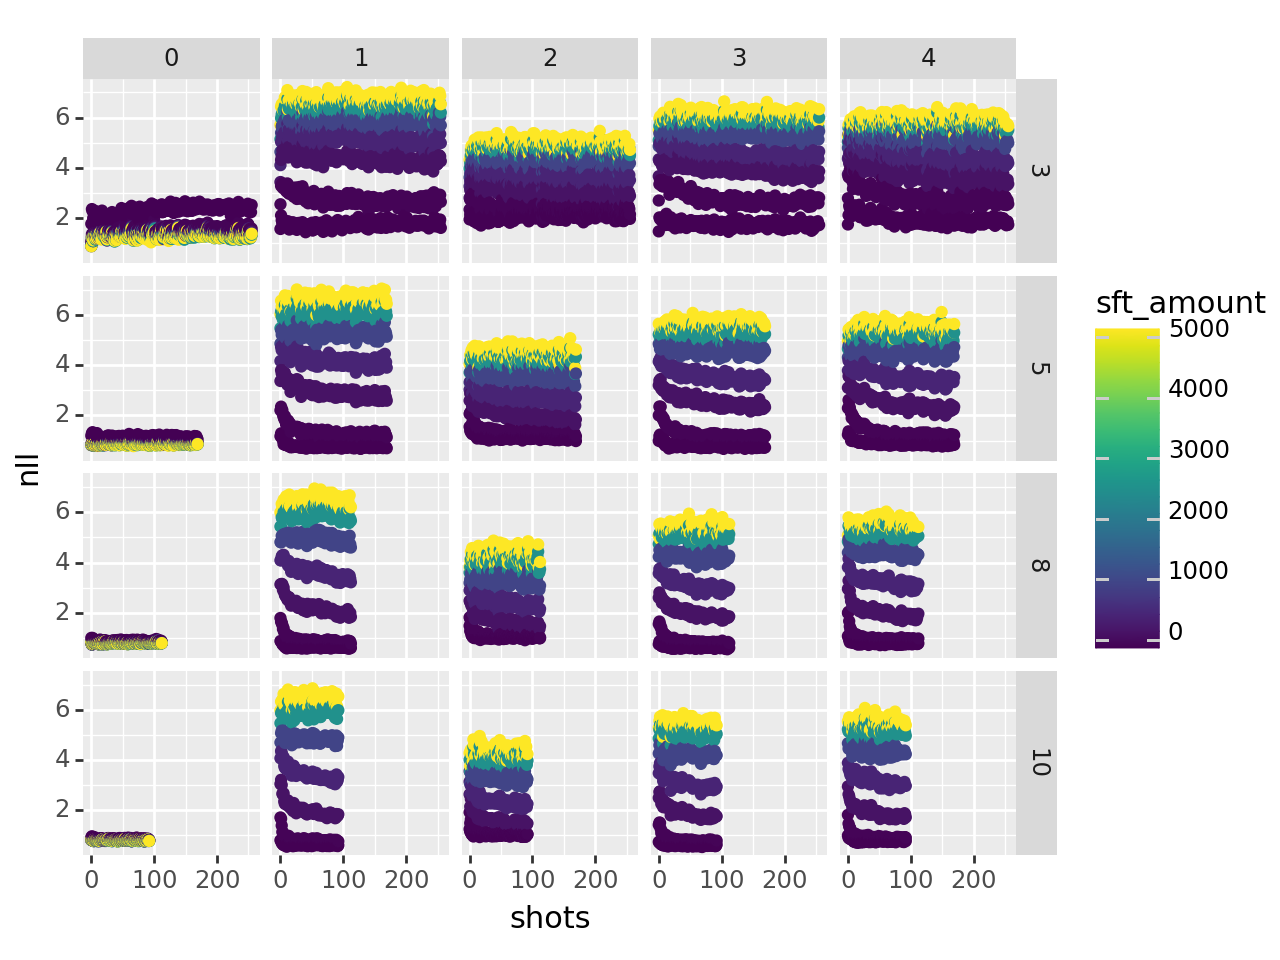

In [81]:
plot = (
    ggplot(data, aes(x="shots", y="nll", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

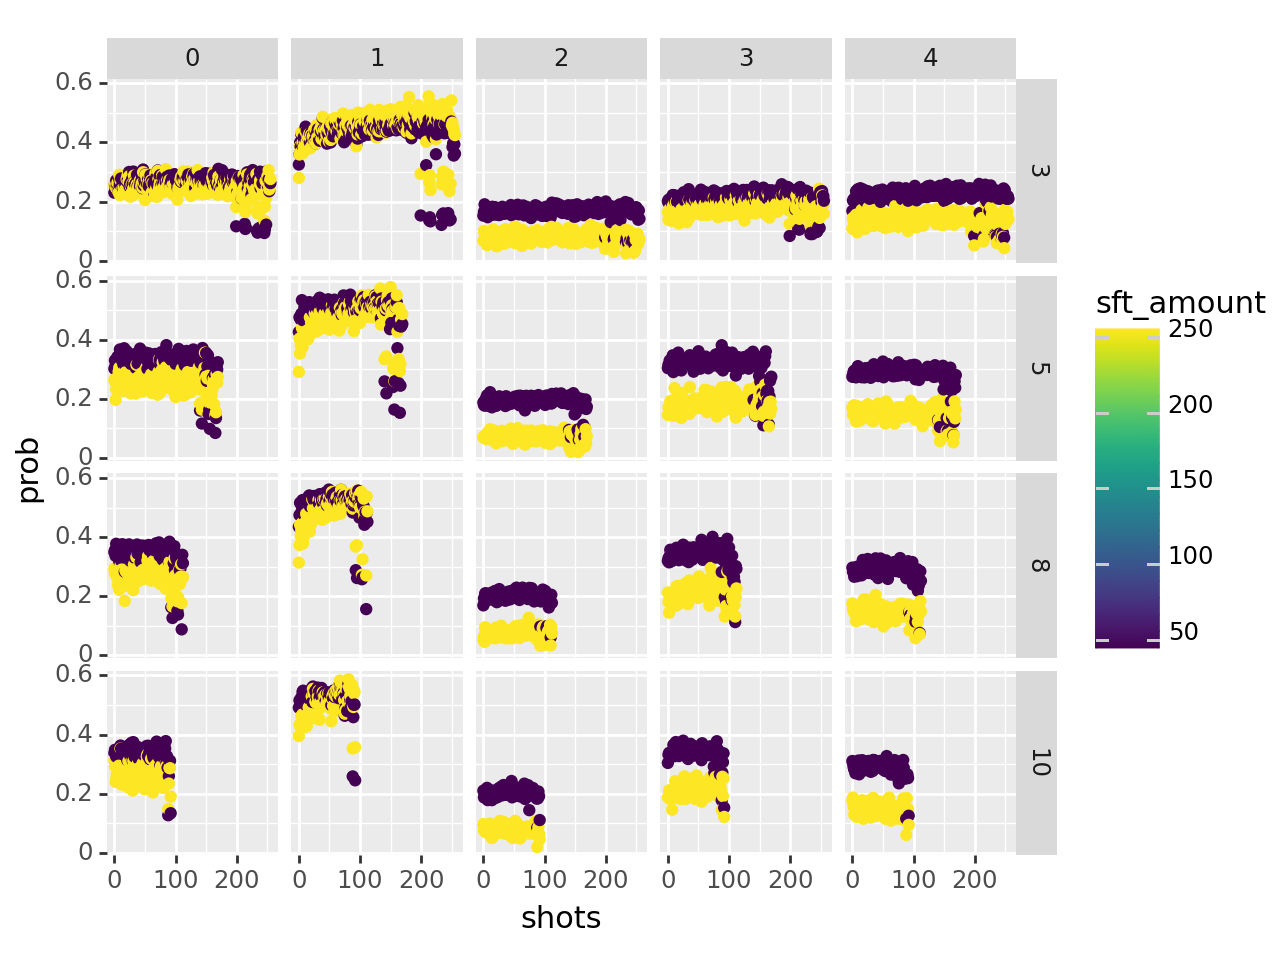

In [32]:
plot = (
    ggplot(data[data["sft"] == 1], aes(x="shots", y="prob", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

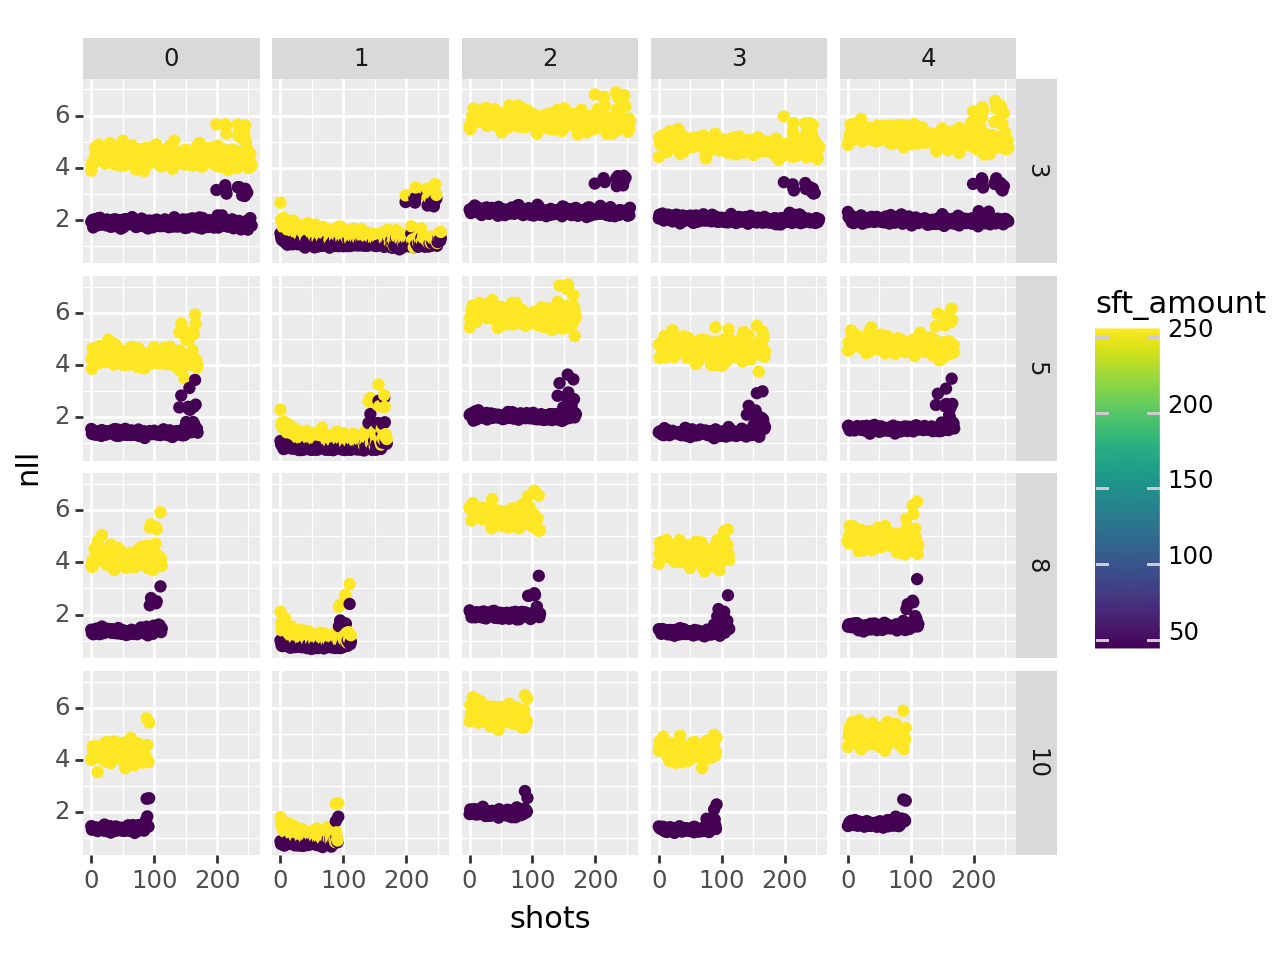

In [20]:
plot = (
    ggplot(data, aes(x="shots", y="nll", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

## MSE analysis

In [2]:
dfs = []
pretrain: str="1,1,1,1,1"
sft: str="1,0,0,0,0"
layers: str="1,2,3,4,8,12,16"
for layer in layers.split(","):
    # set up dir
    directory = f"figs/{pretrain}-{sft}/"
    if os.path.exists(f"{directory}/all_law_params-{layer}-sft.csv"):
        # load data
        data = pd.read_csv(f"{directory}/all_law_params-{layer}-sft.csv")
        data['layers'] = int(layer)
        dfs.append(data)
    else:
        print(f"File {directory}/all_law_params-{layer}-sft.csv does not exist")

# format df
df_all = pd.concat(dfs)
order = list(map(str, sorted(df_all['layers'].unique())))
df_all['layers'] = pd.Categorical(df_all['layers'].astype(str), categories=order, ordered=True)

# drop sft_amount == "none"
df_all = df_all[df_all['sft_amount'] != "none"]
df_all['sft_amount'] = df_all['sft_amount'].astype(float)

In [3]:
df_all

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,rmse,nrmse,C,alpha,n_c,layers
0,0.0,3,0,bayesian,0.014282,0.168797,0.159583,0.025997,0.089526,0.299209,0.087901,NaN,NaN,NaN,1
1,0.0,3,1,bayesian,0.517847,0.199783,0.160128,0.025997,0.139895,0.374026,0.109880,NaN,NaN,NaN,1
2,0.0,3,2,bayesian,0.027260,0.144286,0.160618,0.025997,0.125131,0.353739,0.103921,NaN,NaN,NaN,1
3,0.0,3,3,bayesian,0.377686,0.198030,0.155233,0.025997,0.116200,0.340881,0.100143,NaN,NaN,NaN,1
4,0.0,3,4,bayesian,0.062925,0.190270,0.145870,0.025997,0.137834,0.371261,0.109068,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,5000.0,10,3,bounded,NaN,NaN,NaN,5.424638,0.032319,0.179776,0.061099,1.878804,2.715995,2.124388,16
556,5000.0,10,3,logistic,NaN,NaN,NaN,0.002289,0.033089,0.181905,0.061823,0.002232,1.274660,3.327459,16
557,5000.0,10,4,power,NaN,NaN,NaN,5.539362,0.043504,0.208576,0.070887,0.862824,2.118194,NaN,16
558,5000.0,10,4,bounded,NaN,NaN,NaN,5.432049,0.037340,0.193237,0.065674,1.814331,3.120501,1.946952,16


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


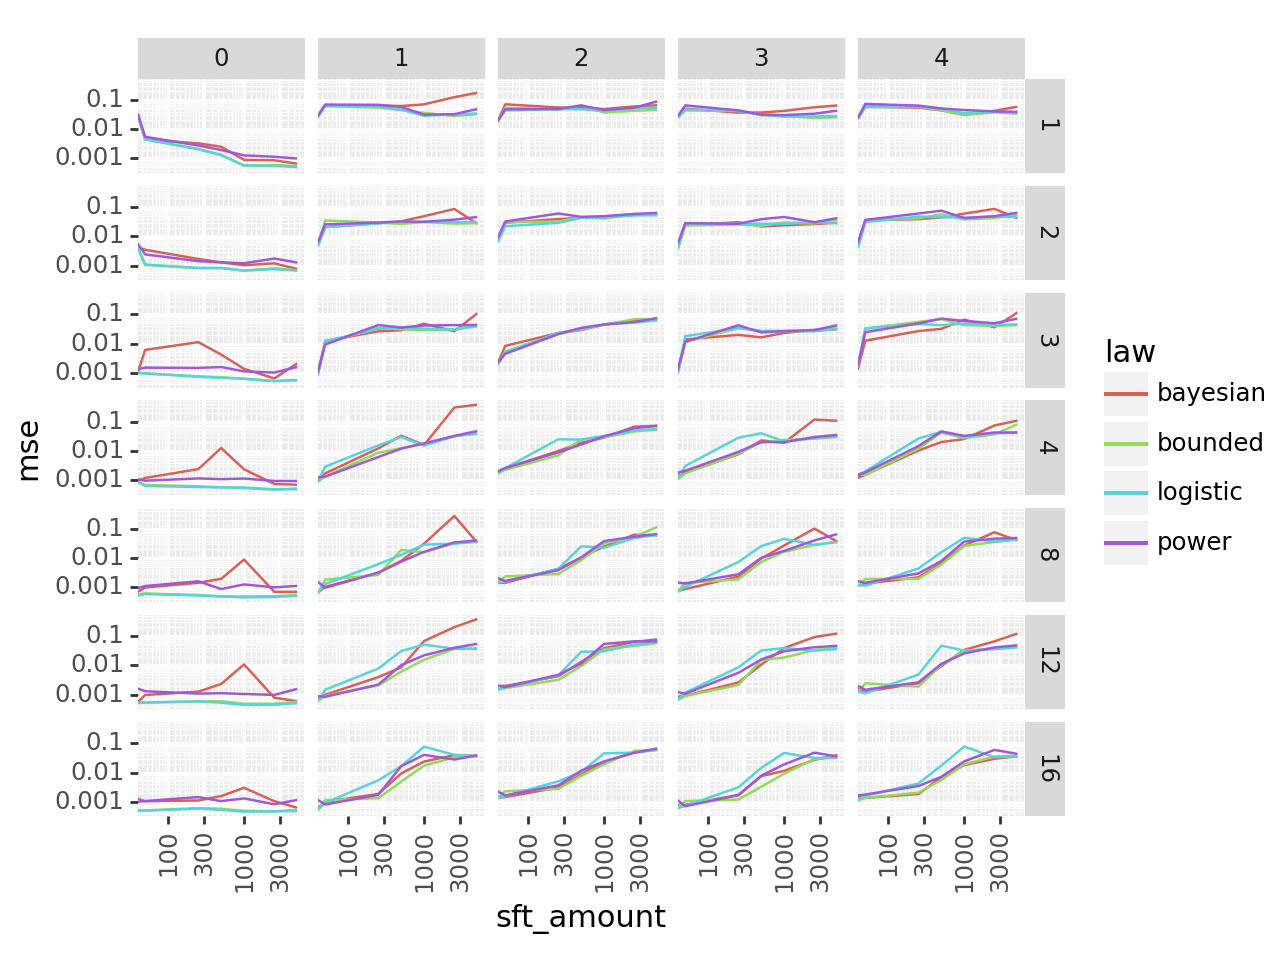

In [7]:
plot = (
    ggplot(df_all[(df_all["k"] == 10)], aes(x='sft_amount', y='mse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


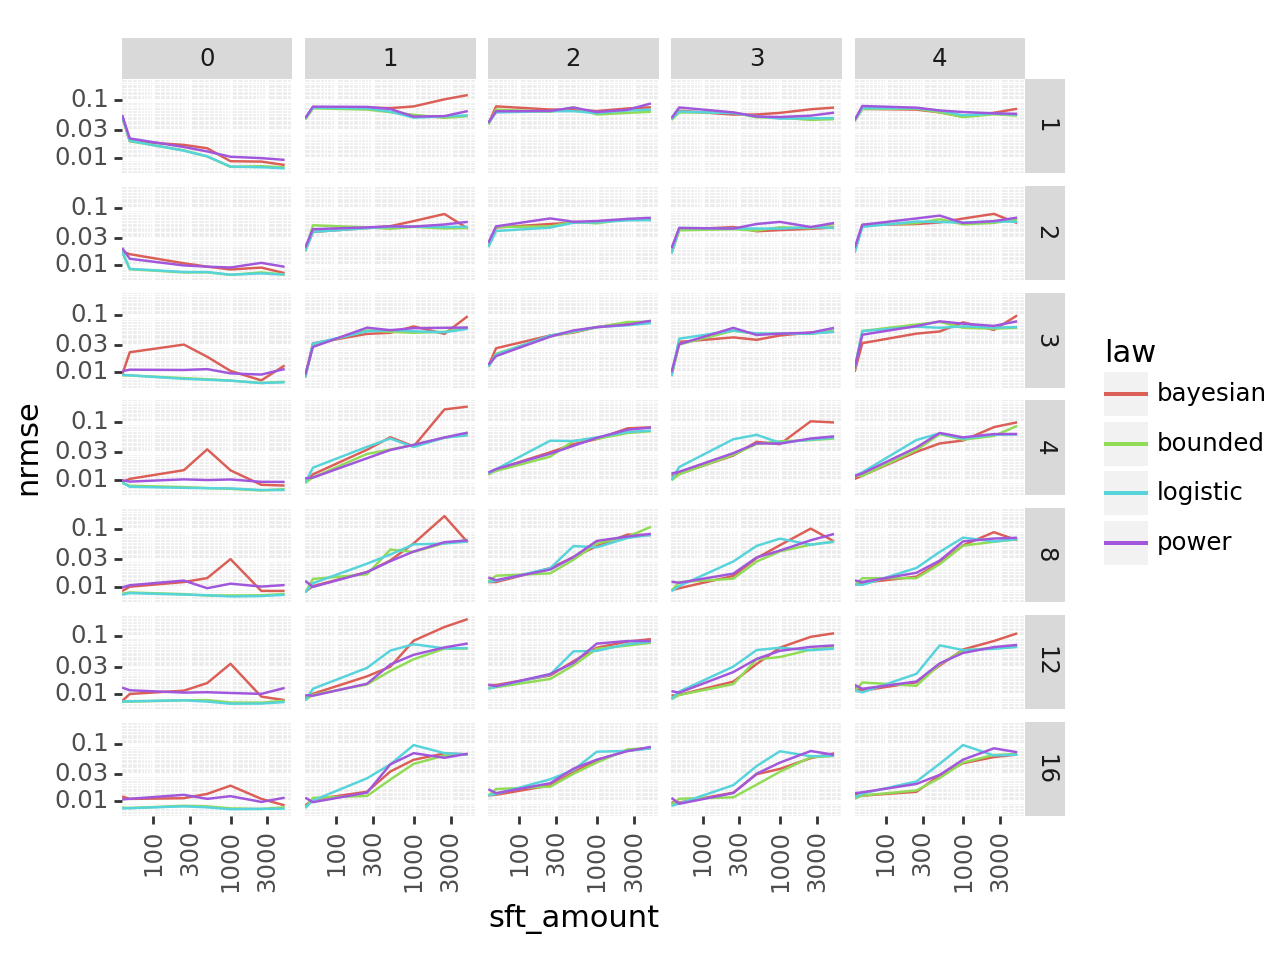

In [10]:
plot = (
    ggplot(df_all[(df_all["k"] == 10)], aes(x='sft_amount', y='nrmse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [41]:
df_all = df_all[df_all['law'] == 'bayesian']
df_all

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,C,alpha,n_c,layers
0,0.0,3,0,bayesian,0.019674,0.147148,0.125671,1.845644,0.088883,NaN,NaN,NaN,1
1,0.0,3,1,bayesian,0.239009,0.214668,0.121395,1.845644,0.137650,NaN,NaN,NaN,1
2,0.0,3,2,bayesian,0.397768,0.145471,0.161931,1.845644,0.106110,NaN,NaN,NaN,1
3,0.0,3,3,bayesian,0.250321,0.196507,0.105006,1.845644,0.113368,NaN,NaN,NaN,1
4,0.0,3,4,bayesian,0.093228,0.160974,0.116079,1.845644,0.135997,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,5000.0,10,0,bayesian,0.909116,0.475441,0.001569,0.001004,0.000601,NaN,NaN,NaN,16
541,5000.0,10,1,bayesian,0.000268,0.084418,0.071891,0.001004,0.036079,NaN,NaN,NaN,16
542,5000.0,10,2,bayesian,0.062650,0.150061,0.003313,0.001004,0.061002,NaN,NaN,NaN,16
543,5000.0,10,3,bayesian,0.015231,0.142806,0.004896,0.001004,0.031540,NaN,NaN,NaN,16


In [42]:
# df = pd.melt(df_all, id_vars=['sft_amount', 'k', 'hmm', 'layers'], value_vars=['gammas', 'betas'], var_name='metric', value_name='value')
from copy import deepcopy

df = deepcopy(df_all)
df['diff'] = df['gammas'] - df['betas']
df

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,C,alpha,n_c,layers,diff
0,0.0,3,0,bayesian,0.019674,0.147148,0.125671,1.845644,0.088883,NaN,NaN,NaN,1,0.021477
1,0.0,3,1,bayesian,0.239009,0.214668,0.121395,1.845644,0.137650,NaN,NaN,NaN,1,0.093272
2,0.0,3,2,bayesian,0.397768,0.145471,0.161931,1.845644,0.106110,NaN,NaN,NaN,1,-0.016460
3,0.0,3,3,bayesian,0.250321,0.196507,0.105006,1.845644,0.113368,NaN,NaN,NaN,1,0.091501
4,0.0,3,4,bayesian,0.093228,0.160974,0.116079,1.845644,0.135997,NaN,NaN,NaN,1,0.044895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,5000.0,10,0,bayesian,0.909116,0.475441,0.001569,0.001004,0.000601,NaN,NaN,NaN,16,0.473872
541,5000.0,10,1,bayesian,0.000268,0.084418,0.071891,0.001004,0.036079,NaN,NaN,NaN,16,0.012527
542,5000.0,10,2,bayesian,0.062650,0.150061,0.003313,0.001004,0.061002,NaN,NaN,NaN,16,0.146749
543,5000.0,10,3,bayesian,0.015231,0.142806,0.004896,0.001004,0.031540,NaN,NaN,NaN,16,0.137910


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


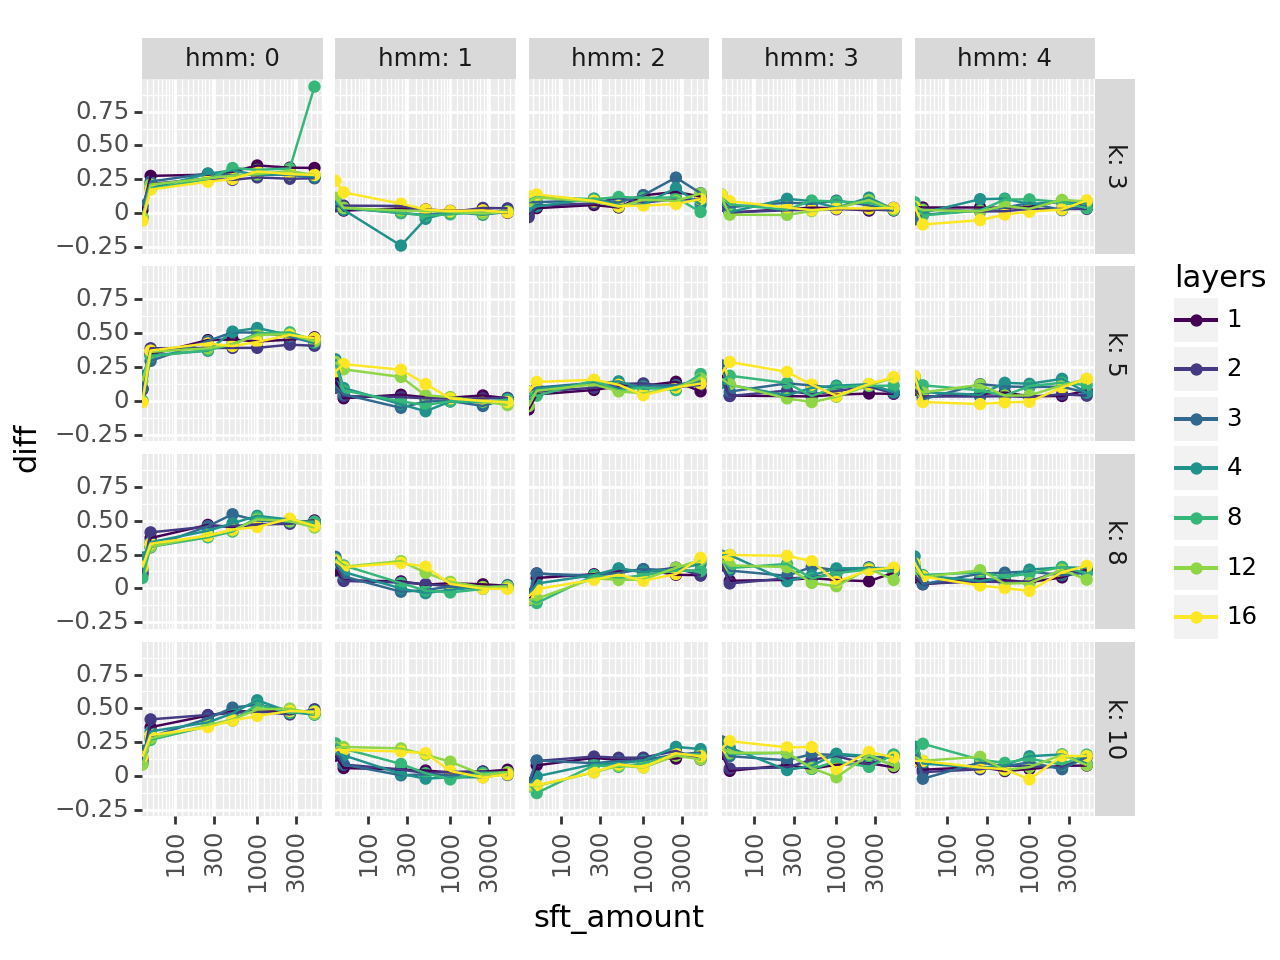

In [43]:
plot = (
    ggplot(df, aes(x='sft_amount', y='diff', color='layers')) + geom_point() +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


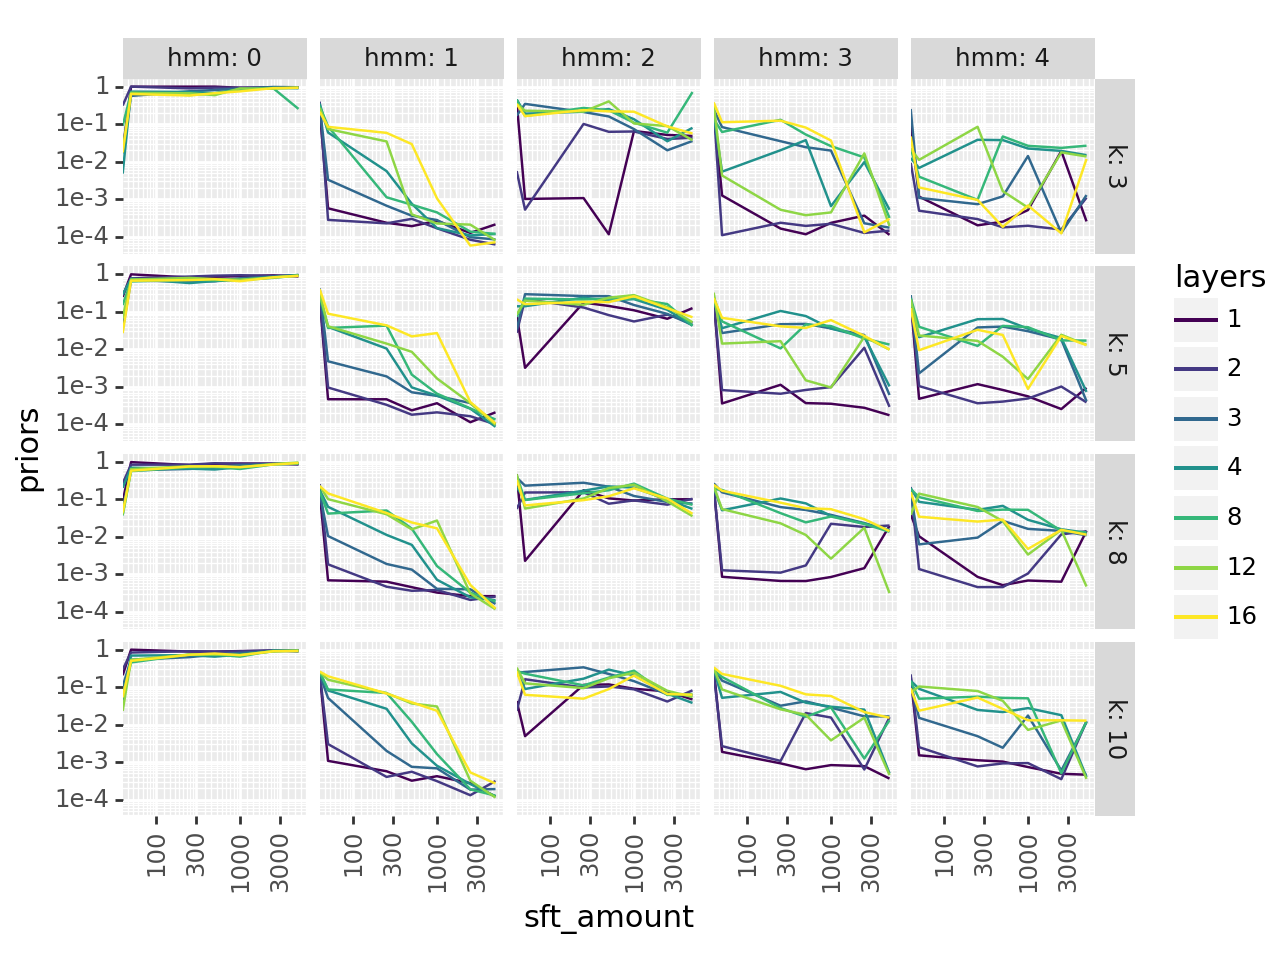

In [45]:
plot = (
    ggplot(df, aes(x='sft_amount', y='priors', color='layers')) +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    scale_y_log10() +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

In [52]:
import math

def inv_sigmoid(x):
    return -math.log((1-x)/x)

In [61]:
df['gammas_s'] = df.apply(lambda x: inv_sigmoid(x['gammas']), axis=1)
df

,sft_amount,k,hmm,law,priors,gammas,betas,K,mse,C,alpha,n_c,layers,diff,priors_s,gammas_s
0,0.0,3,0,bayesian,0.019674,0.147148,0.125671,1.845644,0.088883,NaN,NaN,NaN,1,0.021477,-3.908595,-1.757148
1,0.0,3,1,bayesian,0.239009,0.214668,0.121395,1.845644,0.137650,NaN,NaN,NaN,1,0.093272,-1.158121,-1.297016
2,0.0,3,2,bayesian,0.397768,0.145471,0.161931,1.845644,0.106110,NaN,NaN,NaN,1,-0.016460,-0.414775,-1.770577
3,0.0,3,3,bayesian,0.250321,0.196507,0.105006,1.845644,0.113368,NaN,NaN,NaN,1,0.091501,-1.096900,-1.408269
4,0.0,3,4,bayesian,0.093228,0.160974,0.116079,1.845644,0.135997,NaN,NaN,NaN,1,0.044895,-2.274838,-1.650999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,5000.0,10,0,bayesian,0.909116,0.475441,0.001569,0.001004,0.000601,NaN,NaN,NaN,16,0.473872,2.302886,-0.098315
541,5000.0,10,1,bayesian,0.000268,0.084418,0.071891,0.001004,0.036079,NaN,NaN,NaN,16,0.012527,-8.222541,-2.383776
542,5000.0,10,2,bayesian,0.062650,0.150061,0.003313,0.001004,0.061002,NaN,NaN,NaN,16,0.146749,-2.705491,-1.734120
543,5000.0,10,3,bayesian,0.015231,0.142806,0.004896,0.001004,0.031540,NaN,NaN,NaN,16,0.137910,-4.169082,-1.792177


/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


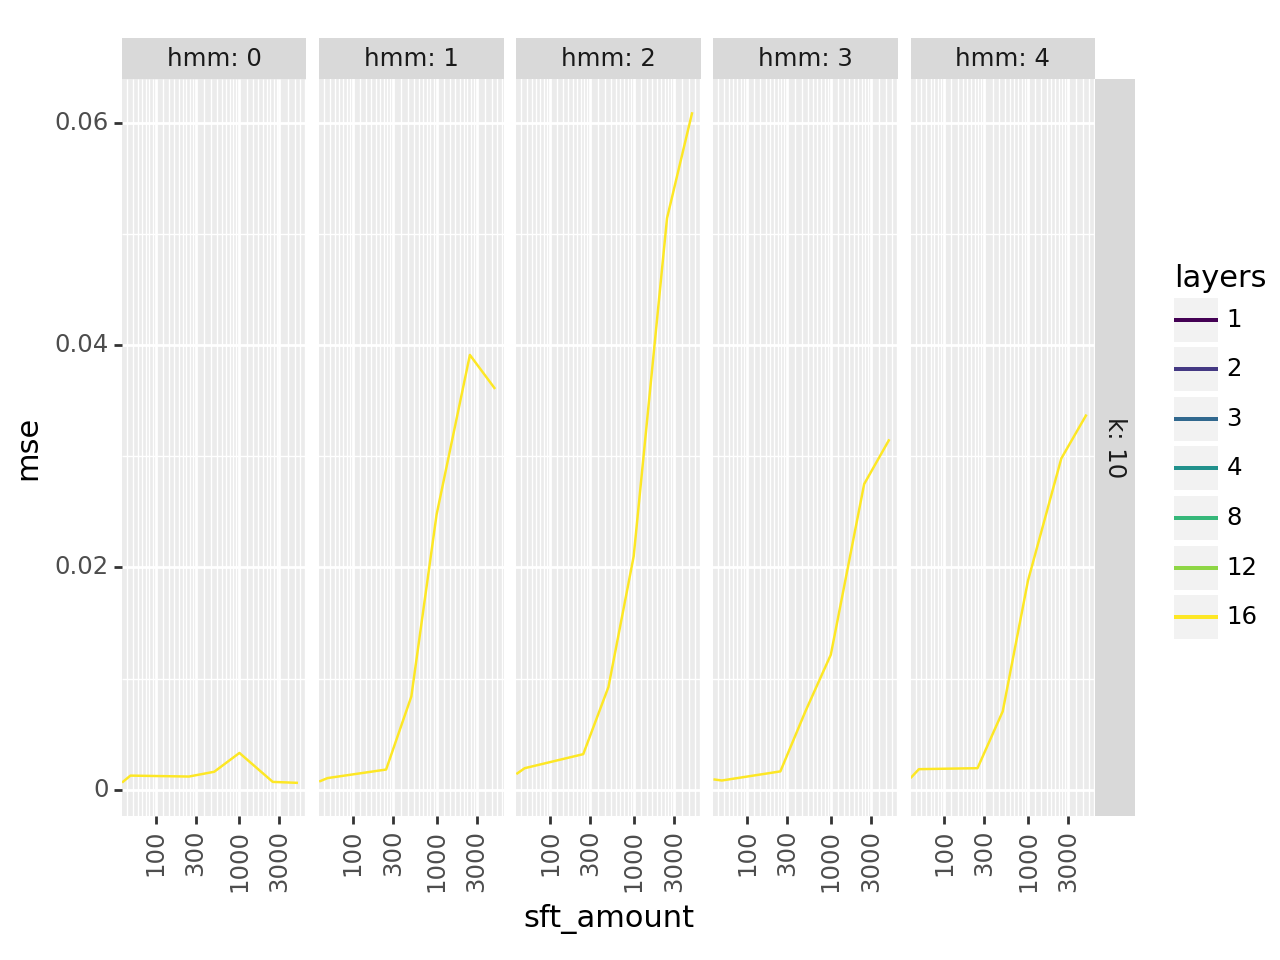

In [70]:
plot = (
    ggplot(df[(df["layers"] == '16') & (df["k"] == 10)], aes(x='sft_amount', y='mse', color='layers')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both") + scale_x_log10()
)
print(plot)